In [1]:
import intake
import matplotlib.pyplot as plt
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import os

col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [3]:
query = col.search(
    experiment_id="historical",  
    table_id="SImon",            
    variable_id="sithick"         
)

print(query.df.head())

  activity_id institution_id     source_id experiment_id  member_id table_id  \
0        CMIP      NOAA-GFDL      GFDL-CM4    historical   r1i1p1f1    SImon   
1        CMIP      NOAA-GFDL      GFDL-CM4    historical   r1i1p1f1    SImon   
2        CMIP           IPSL  IPSL-CM6A-LR    historical   r8i1p1f1    SImon   
3        CMIP           IPSL  IPSL-CM6A-LR    historical  r29i1p1f1    SImon   
4        CMIP           IPSL  IPSL-CM6A-LR    historical  r31i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0     sithick         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1     sithick         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2     sithick         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
3     sithick         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
4     sithick         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   

   dcpp_init_year   version  
0             

In [4]:
ensemble_count = query.df.groupby('source_id')['member_id'].count()

ensemble_count_df = ensemble_count.reset_index()
ensemble_count_df.columns = ['Model', 'Number of Ensembles']

filter_df = ensemble_count_df[ensemble_count_df['Number of Ensembles'] >= 10]

sort_df = filter_df.sort_values(by='Number of Ensembles', ascending=False)

print(sort_df)

            Model  Number of Ensembles
35     MIROC-ES2L                   62
36         MIROC6                   50
25    GISS-E2-1-G                   46
14        CanESM5                   40
30   IPSL-CM6A-LR                   32
1   ACCESS-ESM1-5                   30
42        NorCPM1                   30
27    GISS-E2-1-H                   25
11     CNRM-CM6-1                   21
18      EC-Earth3                   21
47    UKESM1-0-LL                   17
4           CESM2                   11
38  MPI-ESM1-2-HR                   10
39  MPI-ESM1-2-LR                   10


In [13]:
output_dir = "sithick_data"
os.makedirs(output_dir, exist_ok=True)

selected_models = filter_df['Model'].tolist()

# Uncomment to loop through (and indent.)
for chosen_model in selected_models:
    print(f"Processing model: {chosen_model}")

# chosen_model = "INM-CM5-0"

    filtered_ensembles = query.df[query.df['source_id'] == chosen_model]
    sithick_data = {}
    
    #loop
    for _, row in filtered_ensembles.iterrows():
        member_id = row['member_id']
        dataset_url = row['zstore'] 
    
        print(f"  Processing ensemble: {member_id}")
    
        try:
            ds = xr.open_zarr(dataset_url, consolidated=True)
    
            time = ds['time'].data
            if isinstance(time[0], cftime.datetime):
                time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
            else:
                time_mask = time >= np.datetime64('2000-01-01')
    
            ds_filtered_time = ds.sel(time=time_mask)
    
            if 'lat' in ds.coords:
                lat = ds['lat']
            elif 'latitude' in ds.coords:
                lat = ds['latitude']
            elif 'nav_lat' in ds.coords:
                lat = ds['nav_lat']
            else:
                print(f"No latitude variable found for {member_id}. Skipping.")
                continue
    
            mask = (lat >= 75).compute()
            ds_north_75 = ds_filtered_time.where(mask, drop=True)
    
            if {'j', 'i'}.issubset(ds_north_75.dims):
                spatial_dims = ['j', 'i']
            elif {'y', 'x'}.issubset(ds_north_75.dims):
                spatial_dims = ['y', 'x']
            elif {'nj', 'ni'}.issubset(ds_north_75.dims):
                spatial_dims = ['nj', 'ni']
            elif {'lat', 'lon'}.issubset(ds_north_75.dims):
                spatial_dims = ['lat', 'lon']
            else:
                print(f"    Unknown spatial dimensions for {member_id}. Skipping.")
                continue
    
            if 'sithick' in ds_north_75.data_vars:
                sithick_mean = ds_north_75['sithick'].mean(dim=spatial_dims)
    
                sithick_series = sithick_mean.to_series()
                sithick_data[member_id] = sithick_series
            else:
                print(f"    'sithick' not found for {member_id}. Skipping.")
    
        except Exception as e:
            print(f"    Failed to process {member_id}: {e}")
    
    sithick_df = pd.DataFrame(sithick_data)
    
    csv_filename = f"{output_dir}/{chosen_model}_sithick.csv"
    sithick_df.to_csv(csv_filename, index=True)
    
    print(f"Saved {chosen_model} data to {csv_filename}\n")


Processing model: ACCESS-ESM1-5
  Processing ensemble: r5i1p1f1
  Processing ensemble: r4i1p1f1
  Processing ensemble: r11i1p1f1
  Processing ensemble: r10i1p1f1
  Processing ensemble: r6i1p1f1
  Processing ensemble: r7i1p1f1
  Processing ensemble: r8i1p1f1
  Processing ensemble: r9i1p1f1
  Processing ensemble: r3i1p1f1
  Processing ensemble: r2i1p1f1
  Processing ensemble: r12i1p1f1
  Processing ensemble: r13i1p1f1
  Processing ensemble: r15i1p1f1
  Processing ensemble: r19i1p1f1
  Processing ensemble: r1i1p1f1
  Processing ensemble: r16i1p1f1
  Processing ensemble: r14i1p1f1
  Processing ensemble: r18i1p1f1
  Processing ensemble: r17i1p1f1
  Processing ensemble: r20i1p1f1
  Processing ensemble: r28i1p1f1
  Processing ensemble: r26i1p1f1
  Processing ensemble: r30i1p1f1
  Processing ensemble: r29i1p1f1
  Processing ensemble: r25i1p1f1
  Processing ensemble: r27i1p1f1
  Processing ensemble: r24i1p1f1
  Processing ensemble: r23i1p1f1
  Processing ensemble: r22i1p1f1
  Processing ensembl

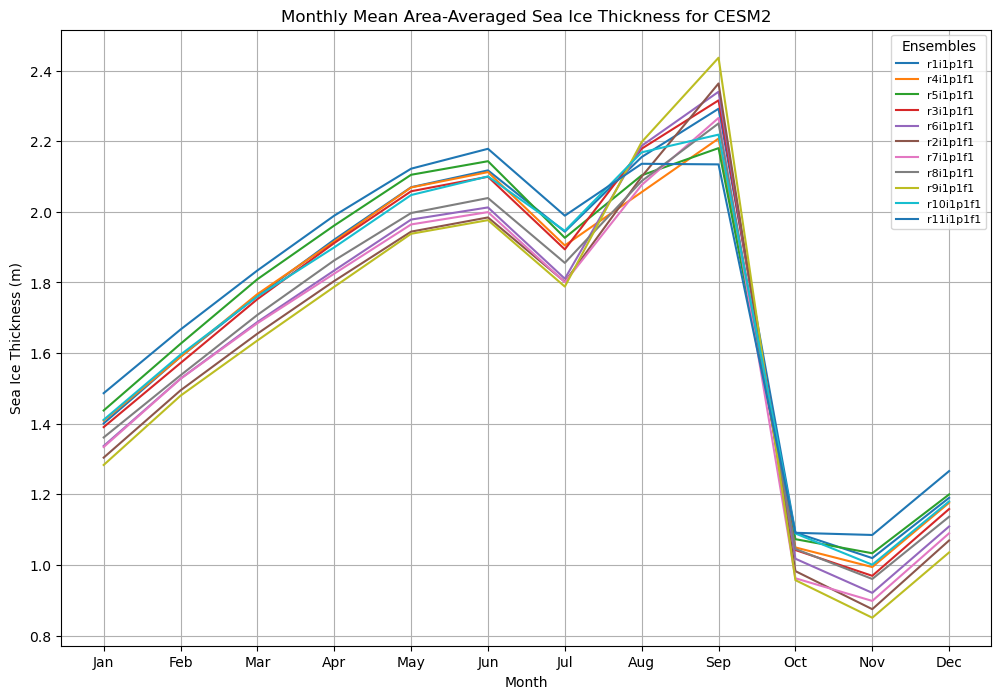

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Specify the selected model
chosen_model = "CESM2"  
csv_filename = f"sithick_data/{chosen_model}_sithick.csv"

# Load data and ensure index is a datetime format
sithick_df = pd.read_csv(csv_filename, index_col=0)
sithick_df.index = pd.to_datetime(sithick_df.index)  # Convert index to datetime

# Compute monthly mean
sithick_mean = sithick_df.groupby(sithick_df.index.month).mean()

# Plot Monthly Mean
plt.figure(figsize=(12, 8))
for member_id in sithick_df.columns:
    plt.plot(sithick_mean.index.values, sithick_mean[member_id].values, label=member_id)

plt.title(f'Monthly Mean Area-Averaged Sea Ice Thickness for {chosen_model}')
plt.xlabel('Month')
plt.ylabel('Sea Ice Thickness (m)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Ensembles', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


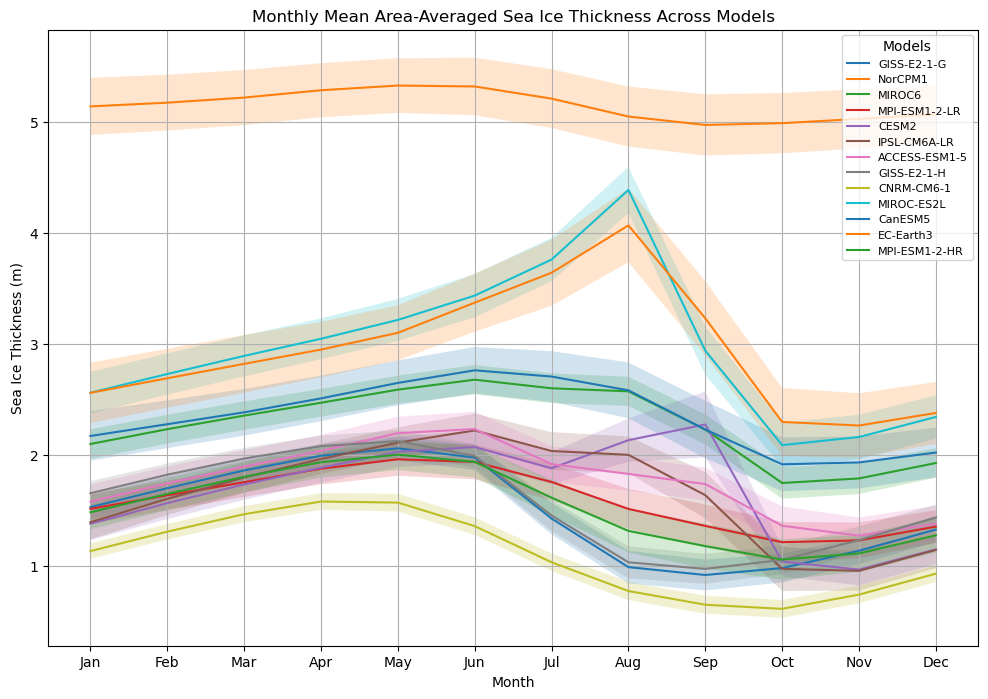

In [29]:
import glob

csv_dir = "sithick_data/"
csv_files = glob.glob(f"{csv_dir}*_sithick.csv")

model_monthly_means = {}
model_monthly_stds = {}

# loop
for csv_file in csv_files:
    model_name = csv_file.split("/")[-1].replace("_sithick.csv", "")

    sithick_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    sithick_monthly_mean = sithick_df.groupby(sithick_df.index.month).mean().mean(axis=1)
    sithick_monthly_std = sithick_df.groupby(sithick_df.index.month).std().mean(axis=1)

    # convert to numpy
    model_monthly_means[model_name] = np.array(sithick_monthly_mean)
    model_monthly_stds[model_name] = np.array(sithick_monthly_std)

# convert to dataframe
monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values  

    plt.plot(month_values, mean_values, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.title('Monthly Mean Area-Averaged Sea Ice Thickness Across Models')
plt.xlabel('Month')
plt.ylabel('Sea Ice Thickness (m)')
plt.xticks(range(1, 13), month_labels)
plt.legend(title='Models', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


In [16]:
chosen_model = "CESM2"  
csv_filename = f"sithick_data/{chosen_model}_sithick.csv"

# Load data
sithick_df = pd.read_csv(csv_filename, index_col=0)

# Display the first few rows
print("First 5 rows of the data:")
print(sithick_df.head())


First 5 rows of the data:
                     r1i1p1f1  r4i1p1f1  r5i1p1f1  r3i1p1f1  r6i1p1f1  \
time                                                                    
2000-01-15 12:00:00  1.653085  1.599712  1.726962  1.746154  1.502160   
2000-02-14 00:00:00  1.853478  1.763593  1.873335  1.922810  1.694521   
2000-03-15 12:00:00  2.018525  1.899484  2.011749  2.103611  1.837057   
2000-04-15 00:00:00  2.159341  2.022682  2.172481  2.279453  2.020640   
2000-05-15 12:00:00  2.315053  2.179391  2.326578  2.417877  2.156541   

                     r2i1p1f1  r7i1p1f1  r8i1p1f1  r9i1p1f1  r10i1p1f1  \
time                                                                     
2000-01-15 12:00:00  1.561965  1.700639  1.567956  1.630168   1.752228   
2000-02-14 00:00:00  1.668254  1.903982  1.791078  1.805078   1.888454   
2000-03-15 12:00:00  1.790075  2.062195  1.954694  1.973038   2.078041   
2000-04-15 00:00:00  1.967142  2.174337  2.098711  2.073225   2.241853   
2000-05-15 12:00:0